In [1]:
cd C:/Users/frankh/python/regression_challenge

C:\Users\frankh\python\regression_challenge


In [2]:
pwd

'C:\\Users\\frankh\\python\\regression_challenge'

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import tensorflow        as tf
import os
import random
import time
import datetime

from matplotlib                 import pyplot as pl

from tensorflow	                import keras
from tensorflow.keras.models    import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras           import layers
from tensorflow.keras.layers    import InputLayer
from tensorflow.keras.layers    import Dense
from tensorflow.keras.layers    import Dropout

from sklearn.model_selection     import train_test_split
from sklearn.preprocessing       import StandardScaler
from sklearn.preprocessing       import Normalizer
from sklearn.metrics             import r2_score
from sklearn.compose             import ColumnTransformer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks  import EarlyStopping

debug = False

def reset_seeds():
    seed_value = 1234
    random.seed(seed_value)
    np.random.seed(seed_value) 
    tf.random.set_seed(seed_value)
    tf.compat.v1.set_random_seed(seed_value)
    tf.random.set_seed(seed_value)

In [4]:
unix1 = datetime.datetime.timestamp(datetime.datetime.now())*1000
print(unix1)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())
reset_seeds()
unix2 = datetime.datetime.timestamp(datetime.datetime.now())*1000
print(unix2)

1677697174981.152
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
1677697175202.307


In [5]:
dataset = pd.read_csv("admissions_data.csv")
print(dataset.describe(include='all'))
print(dataset.head())
print(dataset.columns)

       Serial No.   GRE Score  TOEFL Score  University Rating         SOP  \
count  500.000000  500.000000   500.000000         500.000000  500.000000   
mean   250.500000  316.472000   107.192000           3.114000    3.374000   
std    144.481833   11.295148     6.081868           1.143512    0.991004   
min      1.000000  290.000000    92.000000           1.000000    1.000000   
25%    125.750000  308.000000   103.000000           2.000000    2.500000   
50%    250.500000  317.000000   107.000000           3.000000    3.500000   
75%    375.250000  325.000000   112.000000           4.000000    4.000000   
max    500.000000  340.000000   120.000000           5.000000    5.000000   

            LOR         CGPA    Research  Chance of Admit   
count  500.00000  500.000000  500.000000         500.00000  
mean     3.48400    8.576440    0.560000           0.72174  
std      0.92545    0.604813    0.496884           0.14114  
min      1.00000    6.800000    0.000000           0.34000  
2

In [6]:
features = dataset.iloc[:,1:-1]
labels   = dataset.iloc[:,-1]
print(features.columns)

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research'],
      dtype='object')


In [7]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=1)

In [8]:
def print_column_values(dataset):
    if debug :
        print(dataset['GRE Score'].unique())
        print(dataset['TOEFL Score'].unique())
        print(dataset['University Rating'].unique())
        print(dataset['SOP'].unique())
        print(dataset['LOR '].unique())
        print(dataset['CGPA'].unique())
        print(dataset['Research'].unique())

In [9]:
debug = False
print_column_values(features)

In [10]:
numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns
print(numerical_columns)

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research'],
      dtype='object')


In [11]:
ct = ColumnTransformer([('scale',StandardScaler(),  numerical_columns         )], remainder='passthrough')

In [12]:
debug = False
print_column_values(features)

In [13]:
features_train_scale = ct.fit_transform(features_train)
features_test_scale  = ct.transform(features_test)
features_train_scale = pd.DataFrame(features_train_scale, columns = features_train.columns)
features_test_scale  = pd.DataFrame(features_test_scale, columns = features_test.columns)

In [14]:
debug = False
print_column_values(features_train_scale)

In [15]:
val_mse_list = []
val_mae_list = []
lvl_1_list   = [2**I for I in range(2,7)]
lvl_2_list   = [2**J for J in range(1,6)]
epochs_list  = [10*E for E in range(1,11)]
batch_list   = [2**J for J in range(1,5)]
print(lvl_1_list)
print(lvl_2_list)
print(epochs_list)
print(batch_list)
# MIN:  4 32 90       0.03884091228246689
# lvl_1_list  = [32]
# lvl_2_list  = [32]
epochs_list = [60]
batch_list  = [16]
index_list  = 0
features_predict = {}
for I in lvl_1_list:
    for J in lvl_2_list: 
        for E in epochs_list:
            for B in batch_list:
                print('I:J:E:B', I, J, E, B)
                unix1 = datetime.datetime.timestamp(datetime.datetime.now())*1000
                reset_seeds()
                model = Sequential()
                num_features = features_train_scale.shape[1]
                inputs   = InputLayer(input_shape=(num_features,))
                hidden1  = Dense(I, activation='relu')            
                dropout1 = Dropout(0.1)
                hidden2  = Dense(J, activation='relu')            
                dropout2 = Dropout(0.2)
                outputs  = Dense(1)
                model.add(inputs)
                model.add(hidden1)
                model.add(dropout1)
                model.add(hidden2)        
                model.add(dropout2)
                model.add(outputs)
                opt = Adam(learning_rate=0.01)
                model.compile(loss='mse', metrics=['mae'], optimizer=opt)
                stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
                history = model.fit(features_train_scale, labels_train, epochs=E, batch_size=B, verbose=0, validation_split=0.2, callbacks=[stop])
                val_mse, val_mae = model.evaluate(features_test_scale, labels_test, verbose=0)
                features_predict[index_list] = pd.DataFrame(model.predict(features_test_scale))
                unix2 = datetime.datetime.timestamp(datetime.datetime.now())*1000
                unixd = unix2 - unix1
                print(model.layers)
                print(model.summary())
                print(val_mse, val_mae)
                print('elapsed time:', unixd)
                val_mse_list.append([I, J, E, B, val_mse, unixd])
                val_mae_list.append([I, J, E, B, val_mae, unixd])
                index_list += 1


[4, 8, 16, 32, 64]
[2, 4, 8, 16, 32]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[2, 4, 8, 16]
I:J:E:B 4 2 60 16
4/4 [==============================] - 0s 2ms/step
[<keras.layers.core.dense.Dense object at 0x0000012362B82910>, <keras.layers.regularization.dropout.Dropout object at 0x0000012362B82730>, <keras.layers.core.dense.Dense object at 0x0000012362B82E50>, <keras.layers.regularization.dropout.Dropout object at 0x0000012362B82EB0>, <keras.layers.core.dense.Dense object at 0x0000012362B84400>]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 32        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 8)                 64        
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 2)                 18        
                                                                 
 dropout_11 (Dropout)        (None, 2)                 0         
                                                                 
 dense_17 (Dense)            (None, 1)                 3         
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
None
0.006901352200657129 0.062180109322071075
elapsed time: 19084.690673828125


                                                                 
 dense_31 (Dense)            (None, 2)                 34        
                                                                 
 dropout_21 (Dropout)        (None, 2)                 0         
                                                                 
 dense_32 (Dense)            (None, 1)                 3         
                                                                 
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________
None
0.005707846954464912 0.060389429330825806
elapsed time: 18868.19287109375
I:J:E:B 16 4 60 16
4/4 [==============================] - 0s 3ms/step
[<keras.layers.core.dense.Dense object at 0x000001239F75C670>, <keras.layers.regularization.dropout.Dropout object at 0x000001239F75C6A0>, <keras.layers.core.dense.Dense object at 0x000001239F7DE700>, <keras.layers.regularization.dropout.Dropout object at 0x0

                                                                 
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________
None
0.007031177170574665 0.0643627867102623
elapsed time: 19162.082763671875
I:J:E:B 32 4 60 16
4/4 [==============================] - 0s 3ms/step
[<keras.layers.core.dense.Dense object at 0x00000123936C0F70>, <keras.layers.regularization.dropout.Dropout object at 0x00000123936B11F0>, <keras.layers.core.dense.Dense object at 0x00000123936B1730>, <keras.layers.regularization.dropout.Dropout object at 0x00000123936B1790>, <keras.layers.core.dense.Dense object at 0x00000123936B1C70>]
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 32)                256       
                                                                 
 dropout_32 (Dropout)        (

4/4 [==============================] - 0s 2ms/step
[<keras.layers.core.dense.Dense object at 0x000001239A3194F0>, <keras.layers.regularization.dropout.Dropout object at 0x000001239A319640>, <keras.layers.core.dense.Dense object at 0x000001239A319C10>, <keras.layers.regularization.dropout.Dropout object at 0x000001239A3198E0>, <keras.layers.core.dense.Dense object at 0x000001239A319610>]
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 64)                512       
                                                                 
 dropout_42 (Dropout)        (None, 64)                0         
                                                                 
 dense_64 (Dense)            (None, 4)                 260       
                                                                 
 dropout_43 (Dropout)        (None, 4)                 0   

In [20]:
minI      = 0
minJ      = 0
minE      = 0
minB      = 0
minMAE    = 1
minT      = 0
index_cnt = 0
for I,J,E,B,MAE,T in val_mae_list:
    # print(str(I), str(J), str(E), str(B), str(MSE), str(T))
    if MAE<minMAE:
        minI   = I
        minJ   = J
        minE   = E
        minB   = B
        minMAE = MAE
        minT   = T
    if MAE <= 0.050:
        index_cnt += 1
print('MIN:', str(minI), str(minJ), str(minE), str(minB), str(minMAE), str(minT))
print('CNT: index_list :', str(index_list))
print('CNT: index_cnt  :', str(index_cnt))

MIN: 32 32 60 16 0.03937392309308052 18886.2099609375
CNT: index_list : 25
CNT: index_cnt  : 8


In [30]:
features_shape = features_predict[0].shape[0]
print(features_shape)
features_array = np.zeros(shape=(features_shape,index_cnt))
print(features_array.shape)
j = 0
for i in range(index_list):
    if val_mae_list[i][4] <= 0.050:
        features_array[:, j] = features_predict[i].to_numpy().T
        j += 1
print(features_array[0:5])
features_average = pd.DataFrame(np.average(features_array, axis=1))
print(features_average[0:5])
print(features_average.columns)

100
(100, 8)
[[0.64877516 0.68494916 0.67216349 0.64813906 0.6379292  0.65631092
  0.66877365 0.65016413]
 [0.67669219 0.70406342 0.706173   0.70903039 0.68961602 0.70421863
  0.68807763 0.70545268]
 [0.87880033 0.87581897 0.83662462 0.90085334 0.88210058 0.88645095
  0.9157455  0.89964938]
 [0.68875599 0.71806508 0.70242065 0.6678645  0.70621443 0.71869898
  0.70312566 0.71874857]
 [0.79522157 0.81638718 0.79777539 0.80720621 0.80501336 0.82632238
  0.80888921 0.80079865]]
          0
0  0.658401
1  0.697915
2  0.884505
3  0.702987
4  0.807202
RangeIndex(start=0, stop=1, step=1)


In [33]:
features_average.rename(columns={0:'COL'},inplace=True)
print(type(features_average))
print(features_average.iloc[:,0])
print(features_average.columns)
features_average_list = []
for index, row in features_average.iterrows():
    features_average_list.append(row['COL'])
print(features_average_list[0:10])

<class 'pandas.core.frame.DataFrame'>
0     0.658401
1     0.697915
2     0.884505
3     0.702987
4     0.807202
        ...   
95    0.810380
96    0.838992
97    0.571932
98    0.707434
99    0.673477
Name: COL, Length: 100, dtype: float64
Index(['COL'], dtype='object')
[0.6584005951881409, 0.6979154944419861, 0.884505458176136, 0.7029867321252823, 0.8072017431259155, 0.6778538301587105, 0.7309994399547577, 0.6867728531360626, 0.7615325897932053, 0.6586854606866837]


In [34]:
labels_test = pd.DataFrame(labels_test)
labels_test.rename(columns={'Chance of Admit ':'COL'},inplace=True)
print(type(labels_test))
print(labels_test.iloc[:,0])
labels_test_list = []
for index, row in labels_test.iterrows():
    labels_test_list.append(row['COL'])
print(labels_test_list[0:10])

<class 'pandas.core.frame.DataFrame'>
304    0.62
340    0.75
47     0.89
67     0.57
479    0.79
       ... 
11     0.84
192    0.86
92     0.34
221    0.75
110    0.61
Name: COL, Length: 100, dtype: float64
[0.62, 0.75, 0.89, 0.57, 0.79, 0.7, 0.76, 0.74, 0.77, 0.64]


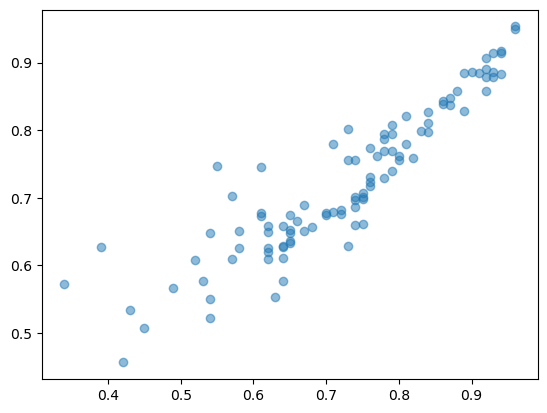

In [35]:
plt.plot(labels_test_list, features_average_list, "o", alpha=0.5)
plt.show()

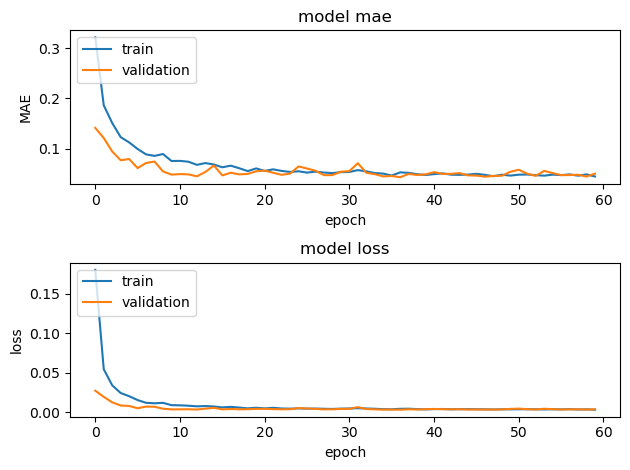

In [36]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['mae'])
ax1.plot(history.history['val_mae'])
ax1.set_title('model mae')
ax1.set_ylabel('MAE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()
fig.savefig('plots.png')

In [37]:
predicted_values = model.predict(features_test_scale) 
print(r2_score(labels_test_list, features_average_list)) 

4/4 [==============================] - 0s 2ms/step
0.8130004311981823


In [ ]:
predicted_values = model.predict(features_test_scale) 
print(r2_score(labels_test_list, labels_test_list)) 